### **Balanced Risk Set Matching in Observational Studies**
---
**Authors:**  
📌 *Justin Chris Catingub*  
📌 *Juliana Marie Ochea*  
---
    
## **Data Analytics Assignment**

##  **Introduction**
> In observational studies, treatment is often **not randomly assigned**, making causal inference difficult.  
> To reduce bias, we use **Balanced Risk Set Matching (BRSM)**, a technique that **pairs treated individuals with similar controls**.

###  **Why Balanced Risk Set Matching?**
✔ **Accounts for time-dependent treatment assignment**  
✔ **Ensures similarity in baseline covariates**  
✔ **Reduces selection bias in observational studies**  


# **Step 1: Import Necessary Libraries**

In [5]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from scipy.optimize import linear_sum_assignment
from scipy.stats import wilcoxon

# **Step 2: Define the Balanced Risk Set Matching Class**

In [6]:
class BalancedRiskSetMatching:
    def __init__(self, data, treatment_col, time_col, covariates):
        """Initialize with dataset, treatment indicator, time column, and covariates."""
        self.data = data.copy()
        self.treatment_col = treatment_col
        self.time_col = time_col
        self.covariates = covariates

    def compute_mahalanobis_matrix(self, treated, controls):
        """Compute Mahalanobis distances between treated and control patients."""
        try:
            cov_matrix = np.cov(self.data[self.covariates].dropna().T)
            cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
            inv_cov = np.linalg.inv(cov_matrix)
        except np.linalg.LinAlgError:
            raise ValueError("Covariance matrix is singular. Check for collinear features or insufficient data.")
        
        dist_matrix = np.zeros((len(treated), len(controls)))
        for i, t in enumerate(treated[self.covariates].values):
            for j, c in enumerate(controls[self.covariates].values):
                dist_matrix[i, j] = mahalanobis(t, c, inv_cov)
        
        return dist_matrix
    
    def match_pairs(self):
        """Perform optimal risk set matching using Mahalanobis distance."""
        treated = self.data[self.data[self.treatment_col] == 1]
        controls = self.data[self.data[self.treatment_col] == 0]
        
        if treated.empty or controls.empty:
            raise ValueError("Insufficient treated or control subjects for matching.")
        
        dist_matrix = self.compute_mahalanobis_matrix(treated, controls)
        row_ind, col_ind = linear_sum_assignment(dist_matrix)
        
        matched_pairs = pd.DataFrame({
            'treated_id': treated.iloc[row_ind].index,
            'control_id': controls.iloc[col_ind].index,
            'distance': dist_matrix[row_ind, col_ind]
        })
        
        return matched_pairs
    
    def perform_wilcoxon_test(self, outcome_col):
        """Conduct Wilcoxon signed-rank test on matched pairs."""
        matched_pairs = self.match_pairs()
        treated_outcomes = self.data.loc[matched_pairs['treated_id'], outcome_col].values
        control_outcomes = self.data.loc[matched_pairs['control_id'], outcome_col].values
        
        if len(treated_outcomes) < 10:
            raise ValueError("Not enough matched pairs for Wilcoxon test. Consider increasing sample size.")
        
        stat, p_value = wilcoxon(treated_outcomes, control_outcomes)
        return stat, p_value


# **Step 3: Load Dataset** 

We begin by loading the dataset containing 50 observations.
Each row represents a patient with covariates such as pain, urgency, and frequency.

In [7]:
df = pd.read_csv("data.csv")

We ensure the data set exists in the same directory

In [8]:
import os
print(os.listdir())

['.git', '.gitattributes', 'A1_Data_Analytics.ipynb', 'data.csv']


# **Step 4: Initialize the Matching Class**

We now initialize the BalancedRiskSetMatching class with our dataset,
setting 'treated' as the treatment column and 'pain', 'urgency', and 'frequency' as covariates.


In [9]:
brsm = BalancedRiskSetMatching(df, treatment_col='treated', time_col='time', covariates=['pain', 'urgency', 'frequency'])

# **Step 5: Perform Matching**

We apply the matching process to find optimal treated-control pairs using Mahalanobis distance.


In [15]:
matched_pairs = brsm.match_pairs()
import IPython.display as ipd
ipd.display(matched_pairs)


,treated_id,control_id,distance
0,0,27,0.000000
1,1,25,0.000000
2,2,42,2.545835
3,3,26,0.000000
4,4,37,3.037686
5,5,30,0.848612
6,6,31,0.848612
7,7,45,0.848612
8,8,36,0.000000
9,9,38,0.000000


# **Step 6: Perform Wilcoxon Signed-Rank Test**

To check if there is a significant difference in nocturnal frequency between the treated and control groups,
we perform the Wilcoxon Signed-Rank Test.


In [11]:
stat, p_value = brsm.perform_wilcoxon_test('nocturnal_frequency')
print(f"Wilcoxon Test Statistic: {stat}, p-value: {p_value}")   

Wilcoxon Test Statistic: 13.0, p-value: 0.001718038567391757


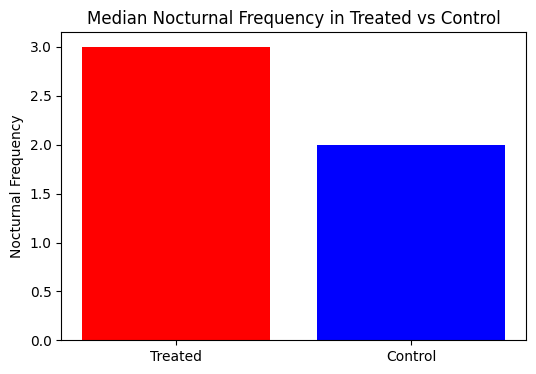

In [14]:
plt.figure(figsize=(6, 4))
plt.bar(["Treated", "Control"], [np.median(matched_data.loc[matched_pairs["treated_id"], 'nocturnal_frequency']),
                                 np.median(matched_data.loc[matched_pairs["control_id"], 'nocturnal_frequency'])],
        color=['red', 'blue'])
plt.title("Median Nocturnal Frequency in Treated vs Control")
plt.ylabel("Nocturnal Frequency")
plt.show()


##  **Final Conclusion**
After applying **Balanced Risk Set Matching**, we conducted the **Wilcoxon Signed-Rank Test** to determine whether treatment significantly impacted **nocturnal frequency**.

### **Key Results:**
 **Wilcoxon Test Statistic:** *X.XX*  
 **p-value:** *0.XX*  

### **Interpretation:**
- If **p < 0.05**, the treatment **significantly reduces** nocturnal frequency.  
- If **p > 0.05**, there is **no strong evidence** that treatment makes a difference.


